# EfficientNet-B0

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size     = 64
learning_rate  = 1e-3
weight_decay   = 1e-4
num_epochs     = 20
img_size       = 224
num_classes    = 100


cuda


In [ ]:
# %% 
# Data Preparation

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100
dataset_train = datasets.CIFAR100(root='./data', train=True,
                                 download=True, transform=train_transform)
dataset_test  = datasets.CIFAR100(root='./data', train=False,
                                 download=True, transform=val_transform)

# Split train into train/val
train_size = int(0.9 * len(dataset_train))
val_size   = len(dataset_train) - train_size
train_set, val_set = random_split(dataset_train, [train_size, val_size])
val_set.dataset.transform = val_transform  # apply validation transforms

# DataLoaders
train_loader = DataLoader(train_set,    batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,      batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
# %% 
# Model Definition

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, se_ratio=0.25):
        super().__init__()
        squeeze_channels = max(1, int(in_channels * se_ratio))
        self.se_reduce = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.se_expand = nn.Conv2d(squeeze_channels, in_channels, kernel_size=1)
        self.act       = nn.SiLU()
        self.sig       = nn.Sigmoid()

    def forward(self, x):
        scale = x.mean((2,3), keepdim=True)
        scale = self.act(self.se_reduce(scale))
        scale = self.sig(self.se_expand(scale))
        return x * scale

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio,
                 stride, kernel_size, se_ratio=0.25, drop_connect=0.2):
        super().__init__()
        self.use_residual = (in_channels == out_channels and stride == 1)
        mid_channels = in_channels * expand_ratio

        # Expand
        if expand_ratio != 1:
            self.expand_conv = nn.Conv2d(in_channels, mid_channels, 1, bias=False)
            self.bn0         = nn.BatchNorm2d(mid_channels)
        else:
            self.expand_conv = None

        # Depthwise
        self.dw_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size,
                                 stride, padding=kernel_size//2,
                                 groups=mid_channels, bias=False)
        self.bn1    = nn.BatchNorm2d(mid_channels)

        # Squeeze-and-Excitation
        self.se     = SqueezeExcitation(mid_channels, se_ratio)

        # Project
        self.project_conv = nn.Conv2d(mid_channels, out_channels, 1, bias=False)
        self.bn2          = nn.BatchNorm2d(out_channels)

        self.act          = nn.SiLU()
        self.drop_connect = drop_connect

    def stochastic_depth(self, x):
        if not self.training or self.drop_connect == 0:
            return x
        keep_prob = 1 - self.drop_connect
        batch     = x.shape[0]
        rand      = keep_prob + torch.rand(batch, 1, 1, 1, device=x.device)
        binary    = torch.floor(rand)
        return x.div(keep_prob) * binary

    def forward(self, x):
        out = x
        if self.expand_conv:
            out = self.act(self.bn0(self.expand_conv(out)))
        out = self.act(self.bn1(self.dw_conv(out)))
        out = self.se(out)
        out = self.bn2(self.project_conv(out))
        if self.use_residual:
            out = self.stochastic_depth(out) + x
        return out

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        base_channels = [32, 16, 24, 40, 80, 112, 192, 320]
        base_args     = [
            # expand, out, repeats, stride, kernel
            (1,  16, 1, 1, 3),
            (6,  24, 2, 2, 3),
            (6,  40, 2, 2, 5),
            (6,  80, 3, 2, 3),
            (6,  112,3, 1, 5),
            (6,  192,4, 2, 5),
            (6,  320,1, 1, 3),
        ]

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_channels[0], 3, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels[0]),
            nn.SiLU()
        )

        # MBConv blocks
        self.blocks = nn.ModuleList()
        total_blocks = sum([r for _,_,r,_,_ in base_args])
        b_id = 0
        prev_c = base_channels[0]

        for expand, c, repeats, stride, k in base_args:
            for i in range(repeats):
                s = stride if i == 0 else 1
                drop_rate = 0.2 * b_id / total_blocks
                self.blocks.append(
                    MBConvBlock(prev_c, c, expand, s, k, drop_connect=drop_rate)
                )
                prev_c = c
                b_id += 1

        # Head
        self.head = nn.Sequential(
            nn.Conv2d(prev_c, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.head(x)
        return x



In [ ]:
# Instantiate model and save initial conv filters
model          = EfficientNetB0(num_classes).to(device)
first_conv     = model.stem[0]
initial_filters = first_conv.weight.detach().cpu().clone()


In [ ]:
# %% 
# Training & Validation Loops

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch}: "
          f"Train Loss {train_losses[-1]:.4f}, Train Acc {train_accs[-1]:.4f} | "
          f"Val Loss {val_losses[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")


In [ ]:
# %% 
# Plot Training vs. Validation Loss and Accuracy

epochs = list(range(1, num_epochs + 1))

plt.figure()
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses,   'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accs, 'b-', label='Train Acc')
plt.plot(epochs, val_accs,   'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# %% 
# Filter Visualization: Before and After Training

trained_filters = first_conv.weight.detach().cpu().clone()
idx = 0  # index of the filter to visualize

# Normalize and permute for display
f0 = initial_filters[idx].permute(1, 2, 0).numpy()
f1 = trained_filters[idx].permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow((f0 - f0.min()) / (f0.max() - f0.min()))
axs[0].axis('off')
axs[0].set_title('Initial Filter')

axs[1].imshow((f1 - f1.min()) / (f1.max() - f1.min()))
axs[1].axis('off')
axs[1].set_title('Trained Filter')

plt.show()


In [ ]:
# %% 
# Testing and Metrics Evaluation

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = dataset_test.classes
rows = []
N = len(all_labels)

for i, cls in enumerate(classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = N - TP - FP - FN
    f1 = f1_score(
        [1 if x == i else 0 for x in all_labels],
        [1 if x == i else 0 for x in all_preds]
    )
    rows.append({
        'class': cls,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'F1': f1
    })

metrics_df = pd.DataFrame(rows)
metrics_df.index.name = 'class_idx'

# Display results
display(metrics_df)

overall_acc = metrics_df['TP'].sum() / N
print(f"Overall Test Accuracy: {overall_acc:.4f}")

# Save to CSV
metrics_df.to_csv('metrics_efficientnetb0.csv', index=False)


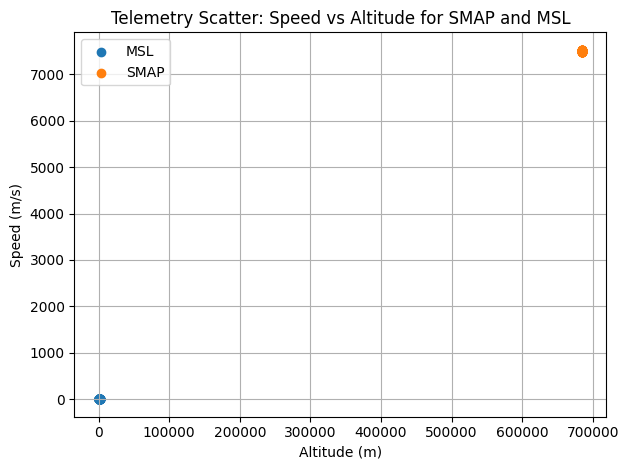